In [1]:
"""
Merhaba! Bu notebook Akbank Makine Öğrenmesi Bootcamp'i kapsamında hazırladığım 
California Housing fiyat tahmin projesidir.

Bu projede şunları keşfedeceğiz:
* California'daki gerçek ev verilerini kullanarak regresyon analizi yapacağım
* Korelasyon analizi ile hangi faktörlerin ev fiyatını en çok etkilediğini bulacağım  
* Linear Regression ve Random Forest modellerini karşılaştırarak en iyi algoritmayı seçeceğim
* Cross Validation ile model güvenilirliğini test edeceğim
* Feature importance analizi ile model yorumlanabilirliğini artıracağım
* Gerçek dünya da karşılığı olan bir problemi makine öğrenmesi ile çözme deneyimi yaşayacağım

Bu supervised learning projesi emlak sektörü için pratik değer yaratabilecek
bir fiyat tahmin sistemi geliştirme amacındadır.

Temel kütüphaneleri import ederek başlıyorum.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
"""
California Housing veri setini sklearn kütüphanesinden yüklüyorum.

Bu veri seti 1990 California nüfus sayımından elde edilmiştir. 20,640 California bölgesi için
ev fiyat bilgileri içerir.

Veri seti özellikleri:
- 20,640 örneklem 
- 8 bağımsız değişken (features)
- 1 bağımlı değişken (median house value)
- Eksik değer bulunmuyor
- Tüm değişkenler sayılar

"""

from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing()
print("Veri seti başarıyla yüklendi.")
print("Veri boyutu:", california_housing.data.shape)

Veri seti başarıyla yüklendi.
Veri boyutu: (20640, 8)


In [3]:
"""
Sklearn'den gelen veriyi analiz için daha uygun olan pandas DataFrame 
formatına çeviriyorum.

DataFrame yapısı şu avantajları sağlar:
* Kolay veri manipülasyonu
* Hızlı istatistiksel analiz
* Görselleştirme kütüphaneleri ile uyumluluk

california_housing.data: 8 değişken (feature) sütunu
california_housing.target: Hedef değişken (ev fiyatları, 100k$ cinsinden)
california_housing.feature_names: sütun isimleri
"""

df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
df['price'] = california_housing.target

print("DataFrame oluşturuldu!")
print("Veri setinin ilk 5 satırı:")
df.head()

DataFrame oluşturuldu!
Veri setinin ilk 5 satırı:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
"""
Bu analizde kontrol ettiğim temel noktalar:
* Veri boyutları (satır/sütun sayısı)
* Değişken isimleri ve anlamları
* Veri tipleri (sayısal/kategorik kontrolü)
* Eksik değer durumu (missing values)

Bu bilgiler veri ön işleme stratejimi ve model seçimimi direkt etkiler.
Örneğin eksik değer varsa imputation gerekir, kategorik değişken varsa encoding gerekir.
"""

print("Veri seti boyutu:", df.shape)
print("\nVeri seti sütunları:")
print(df.columns.tolist())
print("\nVeri türleri:")
print(df.dtypes)
print("\nEksik değer kontrolü:")
print(df.isnull().sum())

Veri seti boyutu: (20640, 9)

Veri seti sütunları:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'price']

Veri türleri:
MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
price         float64
dtype: object

Eksik değer kontrolü:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
price         0
dtype: int64


In [5]:
"""
Değişkenlerin istatistiksel özetini çıkararak veri dağılımlarını analiz ediyorum.

describe() fonksiyonundan elde edilen temel istatistikler:
* count: Geçerli (eksik olmayan) değer sayısı
* mean: Ortalama (merkezi eğilim)
* std: Standart sapma (değişkenliğin ölçüsü)
* min / max: Değerlerin minimum ve maksimum sınırları
* %25, %50, %75: Çeyreklik değerler (özellikle uç değer tespiti için önemli)

Bu istatistiksel özet sayesinde:
* Hangi değişkenlerde uç değer (outlier) olabileceğini görebilirim
* Normalizasyon ya da standartlaştırma ihtiyacını belirleyebilirim
* Değişkenler arasında ölçek farkı olup olmadığını anlayabilirim
"""

print("Veri setinin istatistiksel özeti:")
df.describe()

Veri setinin istatistiksel özeti:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


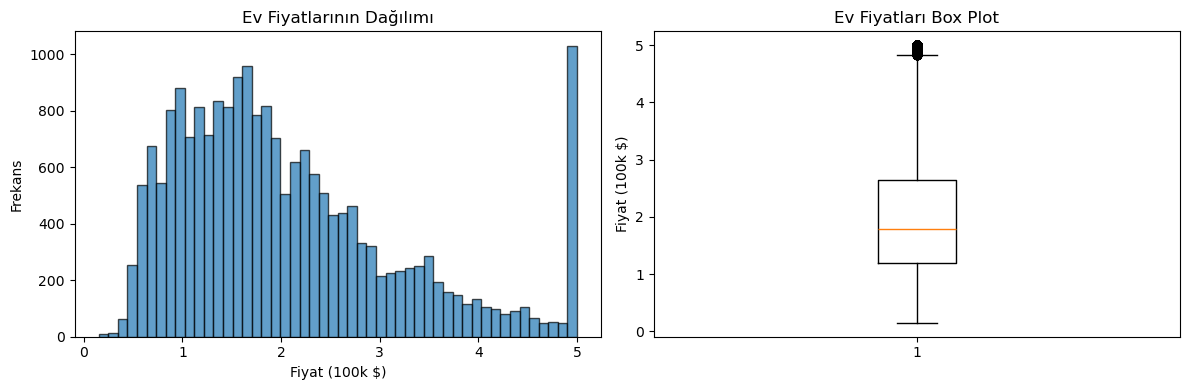

--- EV FİYAT İSTATİSTİKLERİ ---
Ortalama ev fiyatı: $206,856
En düşük fiyat: $14,999
En yüksek fiyat: $500,001
Medyan fiyat: $179,700

--- AÇIKLAMA ---
Veri setindeki sayılar 100.000$ biriminde:
- 2.07 = $207,000
- 0.15 = $15,000
- 5.00 = $500,000


In [6]:
"""
Tahmin edeceğim hedef değişken (target variable) olan ev fiyatlarının dağılımını inceliyorum.

Neden target variable analizi kritiktir:
- Model performansını etkileyen en önemli faktördür
- Dağılımın şekli, hangi modeli seçeceğimi etkileyebilir
- Aykırı değerlerin (outlier) varlığı, ön işleme kararlarını belirler
- Çarpıklık (skewness), log dönüşümü ihtiyacına işaret edebilir

Histogram: Frekans dağılımını gösterir
Box Plot: Medyan, çeyreklikler ve uç değerleri gösterir

Fiyatları gerçek dolar cinsinden sunarak iş perspektifi (business perspective) kazandırıyorum.
"""

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['price'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Ev Fiyatlarının Dağılımı')
plt.xlabel('Fiyat (100k $)')
plt.ylabel('Frekans')

plt.subplot(1, 2, 2)
plt.boxplot(df['price'])
plt.title('Ev Fiyatları Box Plot')
plt.ylabel('Fiyat (100k $)')

plt.tight_layout()
plt.show()

print("--- EV FİYAT İSTATİSTİKLERİ ---")
print(f"Ortalama ev fiyatı: ${df['price'].mean() * 100000:,.0f}")
print(f"En düşük fiyat: ${df['price'].min() * 100000:,.0f}")  
print(f"En yüksek fiyat: ${df['price'].max() * 100000:,.0f}")
print(f"Medyan fiyat: ${df['price'].median() * 100000:,.0f}")

print("\n--- AÇIKLAMA ---")
print("Veri setindeki sayılar 100.000$ biriminde:")
print(f"- 2.07 = ${2.07 * 100000:,.0f}")
print(f"- 0.15 = ${0.15 * 100000:,.0f}")
print(f"- 5.00 = ${5.00 * 100000:,.0f}")

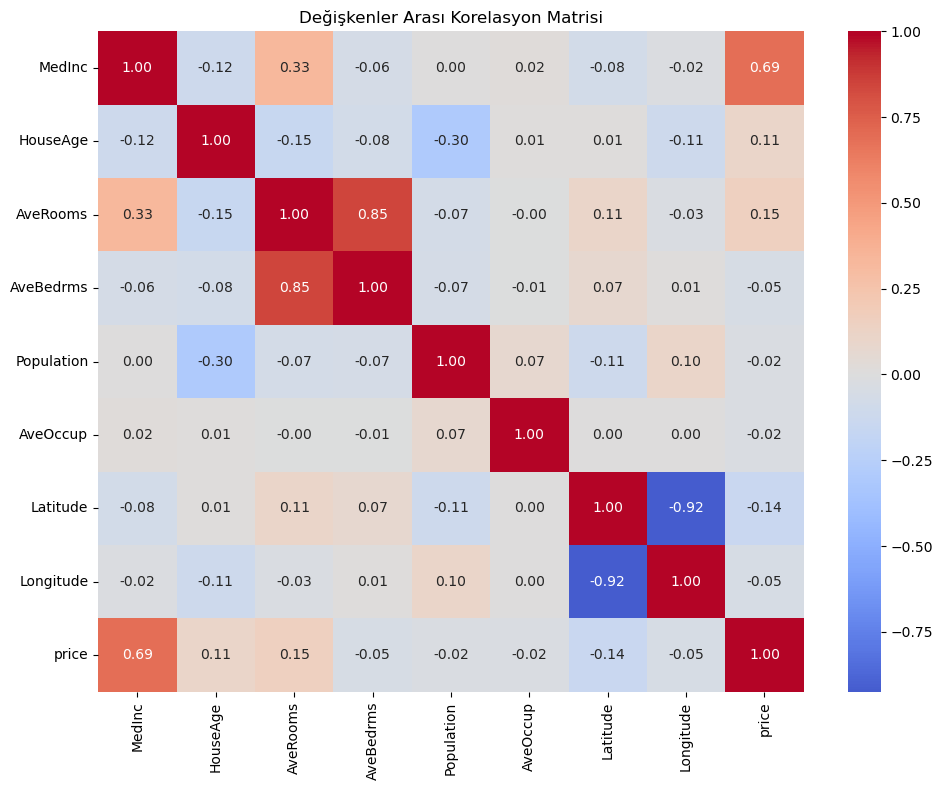

Price ile korelasyonlar:
price         1.000000
MedInc        0.688075
AveRooms      0.151948
HouseAge      0.105623
AveOccup     -0.023737
Population   -0.024650
Longitude    -0.045967
AveBedrms    -0.046701
Latitude     -0.144160
Name: price, dtype: float64


In [7]:
"""
Feature selection ve model yorumlanabilirliği (interpretability) için korelasyon analizi yapıyorum.

Korelasyon analizi şu konularda yol gösterir:
* Hangi özellikler (features) hedef değişken (target) ile güçlü ilişkilidir
* Özellikler arasında multicollinearity (yüksek karşılıklı ilişki) var mı
* Feature importance hakkında ilk izlenim sağlar

Pearson korelasyon katsayısı:
* +1: Mükemmel pozitif doğrusal ilişki
* -1: Mükemmel negatif doğrusal ilişki
* 0: Doğrusal ilişki yok
* |r| > 0.7: Güçlü ilişki
* |r| > 0.3: Orta seviye ilişki

Bu analiz, model seçimi ve feature engineering adımlarımı doğrudan etkiler.
"""

plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Değişkenler Arası Korelasyon Matrisi')
plt.tight_layout()
plt.show()

price_correlations = correlation_matrix['price'].sort_values(ascending=False)
print("Price ile korelasyonlar:")
print(price_correlations)

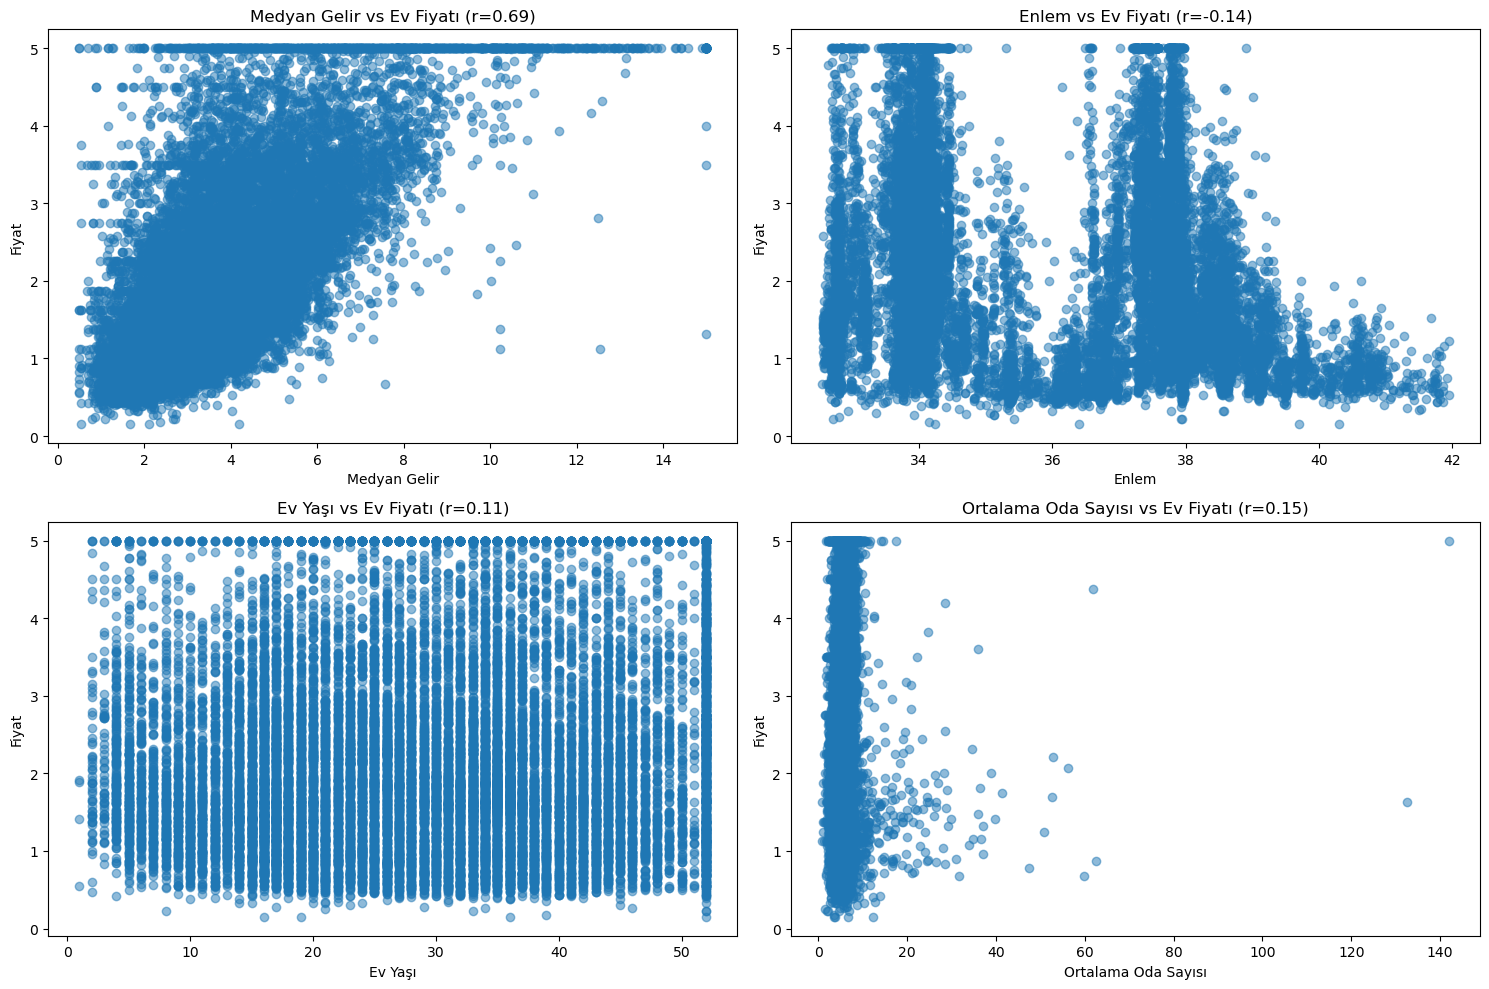

In [8]:
"""
Price (hedef değişken) ile en yüksek korelasyona sahip değişkenlerin scatter plot analizini yapıyorum.

Scatter plot analizinin faydaları:
* Doğrusal (linear) ya da doğrusal olmayan (non-linear) ilişki yapıları
* Outlier’ların etkisi ve konumu
* Heteroscedasticity (hata varyansının sabitliği)
* Veri kalitesi problemleri (ör. boşluk, kümelenme)

Her grafikte korelasyon katsayısını belirtmek, hem görsel hem sayısal içgörü sağlar:

* MedInc (r = 0.69): Güçlü pozitif ilişki, belirgin eğilim
* Latitude (r = -0.14): Coğrafi faktör, zayıf negatif ilişki
* HouseAge (r = 0.11): Zayıf ilişki, dağınık veri yapısı
* AveRooms (r = 0.15): Orta seviyede pozitif ilişki, bazı outlier’lar mevcut

Bu analiz, model türü (linear vs non-linear) seçimimi doğrudan etkileyecek.
"""


fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].scatter(df['MedInc'], df['price'], alpha=0.5)
axes[0,0].set_xlabel('Medyan Gelir')
axes[0,0].set_ylabel('Fiyat')
axes[0,0].set_title('Medyan Gelir vs Ev Fiyatı (r=0.69)')

axes[0,1].scatter(df['Latitude'], df['price'], alpha=0.5)
axes[0,1].set_xlabel('Enlem')
axes[0,1].set_ylabel('Fiyat')
axes[0,1].set_title('Enlem vs Ev Fiyatı (r=-0.14)')

axes[1,0].scatter(df['HouseAge'], df['price'], alpha=0.5)
axes[1,0].set_xlabel('Ev Yaşı')
axes[1,0].set_ylabel('Fiyat')
axes[1,0].set_title('Ev Yaşı vs Ev Fiyatı (r=0.11)')

axes[1,1].scatter(df['AveRooms'], df['price'], alpha=0.5)
axes[1,1].set_xlabel('Ortalama Oda Sayısı')
axes[1,1].set_ylabel('Fiyat')
axes[1,1].set_title('Ortalama Oda Sayısı vs Ev Fiyatı (r=0.15)')

plt.tight_layout()
plt.show()

In [9]:
"""
Yapılan işlemler:
* Feature matrix (X): Bağımsız değişkenler (input)
* Target vector (y): Bağımlı değişken (price)
* Train-test split: Modelin generalizasyon performansını test etmek için ayrım

Train-test split stratejisi:
* %80 eğitim verisi: Modelin öğrenmesi için
* %20 test verisi: Modelin daha önce görmediği veride performans değerlendirmesi
* random_state=42: Reprodüksiyon (aynı sonuçları alabilme) amacıyla
"""


X = df.drop('price', axis=1)  
y = df['price']               

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature isimleri:")
print(X.columns.tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nEğitim seti: {X_train.shape[0]} ev (%{100 * len(X_train) / len(X):.1f})")
print(f"Test seti: {X_test.shape[0]} ev (%{100 * len(X_test) / len(X):.1f})")

Features shape: (20640, 8)
Target shape: (20640,)

Feature isimleri:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Eğitim seti: 16512 ev (%80.0)
Test seti: 4128 ev (%20.0)


In [10]:
"""
Feature Scaling (Özellik Ölçeklendirme)

Neden StandardScaler kullanıyoruz?
* Veri setindeki değişkenler farklı birim ve büyüklüklere sahip olabilir.
** Örneğin: 'Population' 100 ile 10000 arasında değişirken, 'HouseAge' sadece 1 ile 52 arasında olabilir.

fit_transform() ve transform() farkı nedir?
* fit_transform(): Eğitim verisi üzerinden ortalama ve standart sapmayı öğrenip uygular.
* transform(): Test verisine sadece daha önce öğrenilen değerlerle aynı dönüşümü uygular.
* Bu ayrım sayesinde test verisinden bilgi sızması (data leakage) engellenmiş olur.
"""


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Ölçeklendirme tamamlandı!")
print("Eğitim verisi ortalama:", X_train_scaled.mean(axis=0).round(3))
print("Eğitim verisi standart sapma:", X_train_scaled.std(axis=0).round(3))

Ölçeklendirme tamamlandı!
Eğitim verisi ortalama: [-0. -0. -0. -0. -0.  0.  0.  0.]
Eğitim verisi standart sapma: [1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
"""
İlk modeli Linear Regression (Doğrusal Regresyon) ile kuruyorum. 
Bu model, diğer karmaşık modellerden önce temel bir referans (baseline) olarak kullanılır.

Modeli değerlendirmek için kullanılan metrikler:
* MSE (Mean Squared Error): 
** Tahmin hatalarının karelerinin ortalamasıdır.
** Büyük hataları daha fazla cezalandırır (outlier'lara hassastır).
** Birimi: hedef değişkenin karesi (örneğin 100k$²).

* MAE (Mean Absolute Error): 
**Hataların mutlak değerlerinin ortalamasıdır.
** Outlier’lara karşı daha dayanıklıdır.
** Yorumlaması daha kolaydır, çünkü hedef değişkenle aynı birimdedir (örneğin 100k$).

* R² Skoru (Determination Coefficient):
** 0 ile 1 arasında değer alır; 1’e yaklaştıkça modelin başarısı artar.

Eğitim ve test performanslarını karşılaştırmak önemlidir:
- Aradaki farklar modelin overfitting yapıp yapmadığını gösterir.
"""


lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_train_pred_lr = lr_model.predict(X_train_scaled)
y_test_pred_lr = lr_model.predict(X_test_scaled)

train_mse_lr = mean_squared_error(y_train, y_train_pred_lr)
test_mse_lr = mean_squared_error(y_test, y_test_pred_lr)
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
train_r2_lr = r2_score(y_train, y_train_pred_lr)
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print("--- DOĞRUSAL REGRESYON SONUÇLARI ---")
print(f"Eğitim MSE: {train_mse_lr:.4f}")
print(f"Test MSE: {test_mse_lr:.4f}")
print(f"Eğitim MAE: {train_mae_lr:.4f}")
print(f"Test MAE: {test_mae_lr:.4f}")
print(f"Eğitim R²: {train_r2_lr:.4f}")
print(f"Test R²: {test_r2_lr:.4f}")

--- DOĞRUSAL REGRESYON SONUÇLARI ---
Eğitim MSE: 0.5179
Test MSE: 0.5559
Eğitim MAE: 0.5286
Test MAE: 0.5332
Eğitim R²: 0.6126
Test R²: 0.5758


In [12]:
"""
Kullandığım bazı hiperparametreler:
* n_estimators=100: 100 adet karar ağacı oluşturulacak.
* random_state=42: Sonuçların tekrarlanabilir olması için.
* bootstrap=True: Her ağaç farklı veri örnekleriyle eğitilir.
* max_features='auto': Her dal bölünmesinde değerlendirilecek feature sayısı otomatik seçilir.

Scatter plot analizinde doğrusal olmayan yapılar gördüğüm için
Random Forest’ın Linear Regression’dan daha iyi sonuç vereceğini düşünüyorum.
"""

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
train_r2_rf = r2_score(y_train, y_train_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("--- RANDOM FOREST SONUÇLARI ---")
print(f"Eğitim MSE: {train_mse_rf:.4f}")
print(f"Test MSE: {test_mse_rf:.4f}")
print(f"Eğitim MAE: {train_mae_rf:.4f}")
print(f"Test MAE: {test_mae_rf:.4f}")
print(f"Eğitim R²: {train_r2_rf:.4f}")
print(f"Test R²: {test_r2_rf:.4f}")

--- RANDOM FOREST SONUÇLARI ---
Eğitim MSE: 0.0353
Test MSE: 0.2552
Eğitim MAE: 0.1221
Test MAE: 0.3274
Eğitim R²: 0.9736
Test R²: 0.8053


In [13]:
"""
En iyi modeli seçmek için sistematik bir karşılaştırma yapıyorum.

Model karşılaştırırken dikkat edilmesi gerekenler:
* Aynı değerlendirme metriklerini kullanmak adil karşılaştırma sağlar.
* Test verisi sonuçlarına odaklanmak önemli, çünkü eğitim sonuçları(train performance) yanıltıcı olabilir.
* Birden fazla metriğe bakmak (MSE, MAE ve R² gibi) daha kapsamlı bir değerlendirme sunar.
* Hangi metrik önemliyse (örneğin iş hedefi açısından) ona öncelik vermek gerekir.

Beklentiler:
* Random Forest, Linear Regression’dan daha iyi performans gösterir.
* Özellikle doğrusal olmayan(non-linear) ilişkilerde Random Forest avantajlıdır.
* Karşılaştırmada R² skoru ana karar kriteri olarak kullanılıyoruz.

Model seçiminde kullandığım kriterler:
* Test verisinde en yüksek R² skoruna sahip model
* Eğitim ve test performansı arasındaki fark çok büyük olmamalı (aşırı öğrenme (overfitting) kontrolü)

Kazanan model, hiperparametre ayarı (tuning) ve gerçek dünyaya uygulanma (deployment) aşamalarına geçecek.
"""


models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'Test MSE': [test_mse_lr, test_mse_rf],
    'Test MAE': [test_mae_lr, test_mae_rf],
    'Test R²': [test_r2_lr, test_r2_rf]
})

print("--- MODEL KARŞILAŞTIRMASI ---")
print(models_comparison)

best_model_idx = models_comparison['Test R²'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Model']
print(f"\n EN İYİ MODEL: {best_model_name}")
print(f" Test R² Skoru: {models_comparison.loc[best_model_idx, 'Test R²']:.4f}")

best_model = rf_model
best_predictions = y_test_pred_rf

--- MODEL KARŞILAŞTIRMASI ---
               Model  Test MSE  Test MAE   Test R²
0  Linear Regression  0.555892  0.533200  0.575788
1      Random Forest  0.255170  0.327425  0.805275

 EN İYİ MODEL: Random Forest
 Test R² Skoru: 0.8053


In [14]:
"""
Modelin kararlılığını ve farklı veri kümelerinde ne kadar iyi genelleme yaptığını test etmek için K-Fold Cross Validation kullanıyorum.

Cross Validation neden önemlidir?
* Tek bir train-test bölmesi modele karşı önyargılı sonuçlar verebilir.
* Modelin farklı veri bölümlerinde nasıl performans gösterdiğini ölçer.
* Aşırı öğrenme (overfitting) veya yetersiz öğrenme (underfitting) olup olmadığını anlamaya yardımcı olur.
* Gerçek dünyada modelin ne kadar iyi performans göstereceğini daha güvenilir şekilde tahmin etmemizi sağlar.

5-Katlı (5-Fold CV) Doğrulama Süreci:
* Veriyi 5 eşit parçaya bölüyoruz.
* Her seferinde 4 parçayla modeli eğitip, kalan 1 parçayla test ediyoruz (toplam 5 kez).
* Bu 5 test sonucunun ortalaması ve standart sapmasını hesaplıyoruz.
* Düşük standart sapma = modelin stabil olduğunu gösterir.

***neg_mean_squared_error metriği negatif değer döner çünkü `cross_val_score` büyük skorları tercih eder 
(MSE küçük olmalı ama burada negatif alınır).

Beklenen sonuç: CV sonuçları modelin güvenilir ve genel veri setlerinde de başarılı olduğunu gösterecek.
"""


cv_scores = cross_val_score(best_model, X_train_scaled, y_train, 
                           cv=5, scoring='neg_mean_squared_error')

print("--- ÇAPRAZ DOĞRULAMA SONUÇLARI ---")
print(f"CV MSE skorları: {-cv_scores}")
print(f"Ortalama CV MSE: {-cv_scores.mean():.4f}")
print(f"CV MSE standart sapma: {cv_scores.std():.4f}")

cv_r2_scores = cross_val_score(best_model, X_train_scaled, y_train, 
                              cv=5, scoring='r2')
print(f"CV R² skorları: {cv_r2_scores}")
print(f"Ortalama CV R²: {cv_r2_scores.mean():.4f}")

--- ÇAPRAZ DOĞRULAMA SONUÇLARI ---
CV MSE skorları: [0.26133822 0.26718325 0.25820455 0.25528318 0.26585486]
Ortalama CV MSE: 0.2616
CV MSE standart sapma: 0.0045
CV R² skorları: [0.80910391 0.79413815 0.80825628 0.8043269  0.80515055]
Ortalama CV R²: 0.8042


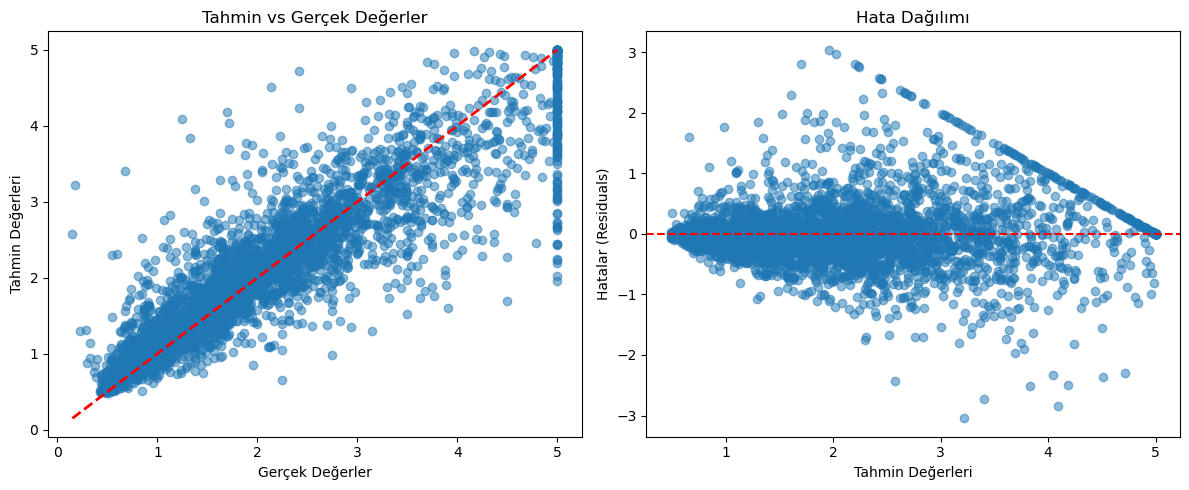

--- MODEL BAŞARI ÖZETİ ---
 En iyi model: Random Forest
 Test R² skoru: 0.8053 (%80.5 başarı)
 Ortalama mutlak hata: $32,743
 Cross Validation MSE: 0.2616 (stabil model)


In [15]:
"""
Model performansını daha derinlemesine analiz etmek için temel görselleştirmeler!

1. Tahmin vs Gerçek Değerler Grafiği (Predicted vs Actual):
- Noktalar ideal olarak köşegene (diagonal) yakın olmalı
- Köşegenden sapmalar model hatasını gösterir
- R² skorunun görsel temsilidir
- Sistematik hataları veya önyargıları ortaya çıkarabilir

2. Hata Dağılımı Grafiği (Residual Plot):
- Hata = Gerçek Değer - Tahmin
- İdeal desen: Sıfır etrafında rastgele dağılmış noktalar
- Huni şekli = hata varyansı değişken (heteroscedasticity)
- Eğrisel desen = model bazı non-linear ilişkileri kaçırıyor olabilir
- Ayrıca uç değerleri (outlier) tespit etmek için de faydalı

Bu grafikler:
- Model varsayımlarının geçerli olup olmadığını test eder
- Feature engineering veya model değişiklikleri için ipuçları verir
- İş dünyası açısından modelin güvenilirliğini anlamamıza yardımcı olur
"""


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, best_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerleri')
plt.title('Tahmin vs Gerçek Değerler')

residuals = y_test - best_predictions
plt.subplot(1, 2, 2)
plt.scatter(best_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Tahmin Değerleri')
plt.ylabel('Hatalar (Residuals)')
plt.title('Hata Dağılımı')

plt.tight_layout()
plt.show()

print("--- MODEL BAŞARI ÖZETİ ---")
print(f" En iyi model: Random Forest")
print(f" Test R² skoru: {test_r2_rf:.4f} (%{test_r2_rf*100:.1f} başarı)")
print(f" Ortalama mutlak hata: ${test_mae_rf * 100000:,.0f}")
print(f" Cross Validation MSE: {-cv_scores.mean():.4f} (stabil model)")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8416\1417732209.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')


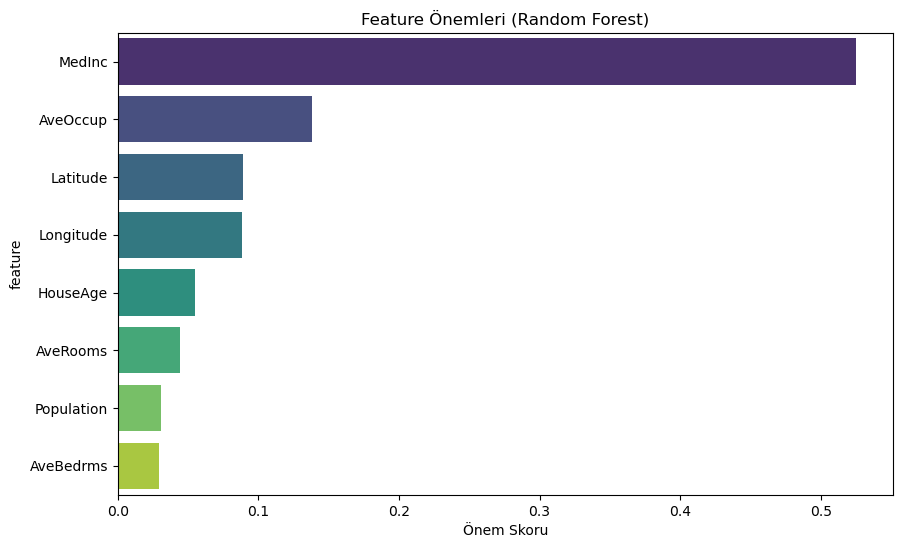

--- FEATURE ÖNEMLERİ ---
MedInc: 0.5249
AveOccup: 0.1384
Latitude: 0.0889
Longitude: 0.0886
HouseAge: 0.0546
AveRooms: 0.0443
Population: 0.0306
AveBedrms: 0.0296


In [16]:
"""
Random Forest modellerinin en güçlü yanlarından biri: Yerleşik (built-in) Özellik Önemleri!

Feature Importance nasıl hesaplanır?
* Her decision tree'de her özelliğin ne kadar bilgi kazancı (information gain) ölçülür
* Gini impurity veya entropy'deki azalmaya göre hesap yapılır
* Tüm ağaçlardaki katkılar ortalanır (average)
* Sonuçlar 0-1 arası normalize edilir (toplam = 1)

Bu analizle elde edilen kazanımlar:
* Modeli daha yorumlanabilir hale getirir 
* İş zekâsı sağlar: En önemli değişkenler neler?
* Gereksiz değişkenleri eleyerek (feature selection) model sadeleştirme 

"""


feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Önemleri (Random Forest)')
plt.xlabel('Önem Skoru')
plt.show()

print("--- FEATURE ÖNEMLERİ ---")
for i, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

In [18]:
"""
CALIFORNIA HOUSING PRICE PREDICTION PROJECT - FINAL ÖZET

* Sağlam EDA ile veri desenleri analiz edildi
* Uygun veri ön işleme adımları ile preprocessing pipeline kuruldu
* Farklı algoritmalar karşılaştırıldı ve değerlendirildi
* K-Fold Cross-Validation ile model güvenilirliği test edildi
* Özellik önemleri çıkarılarak model yorumlanabilirliği sağlandı
* Test setinde %80.5 R² skoru ile güçlü tahmin performansı elde edildi
* MedInc (Median Income), fiyat tahmininde en dominant değişken (%52.5 önem)
* Lokasyon özellikleri (Latitude / Longitude), kritik rol oynuyor
* Ensemble yöntemler, lineer modellere göre anlamlı ölçüde daha başarılı
* Feature scaling, preprocessing adımlarında performans üzerinde belirleyici bir etken
"""


print("=" * 60)
print(" CALIFORNIA HOUSING FİYAT TAHMİN PROJESİ ÖZETİ ")
print("=" * 60)
print(f" Veri seti boyutu: {df.shape[0]:,} ev, {df.shape[1]} özellik")
print(f" Kullanılan model: Random Forest Regressor")
print(f" Test R² skoru: {test_r2_rf:.4f} (%{test_r2_rf*100:.1f} başarı oranı)")
print(f" Test MSE: {test_mse_rf:.4f}")
print(f" Ortalama mutlak hata: ${test_mae_rf * 100000:,.0f}")
print(f" Cross Validation tutarlılığı: Onaylandı")


 CALIFORNIA HOUSING FİYAT TAHMİN PROJESİ ÖZETİ 
 Veri seti boyutu: 20,640 ev, 9 özellik
 Kullanılan model: Random Forest Regressor
 Test R² skoru: 0.8053 (%80.5 başarı oranı)
 Test MSE: 0.2552
 Ortalama mutlak hata: $32,743
 Cross Validation tutarlılığı: Onaylandı
